In [1]:
import pandas as pd
import re
import string

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from google.colab import files
import io

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [34]:
def plot_simple_results(history):
    """
    Упрощенная отрисовка только основных метрик
    """
    plt.figure(figsize=(15, 4))

    epochs = range(1, len(history['train_losses']) + 1)

    # 1. Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_losses'], 'b-', label='Train Loss')
    if 'val_losses' in history:
        plt.plot(epochs, history['val_losses'], 'r-', label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Accuracy
    plt.subplot(1, 3, 2)
    if 'val_accuracies' in history:
        plt.plot(epochs, history['val_accuracies'], 'g-', label='Val Accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)

    # 3. F1-Score
    plt.subplot(1, 3, 3)
    if 'val_f1_scores' in history:
        plt.plot(epochs, history['val_f1_scores'], 'purple', label='Val F1')
        plt.title('F1-Score')
        plt.xlabel('Epochs')
        plt.ylabel('F1-Score')
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Простой вывод в консоль
    print("\nFinal Metrics:")
    print(f"Train Loss: {history['train_losses'][-1]:.4f}")
    if 'val_losses' in history:
        print(f"Val Loss: {history['val_losses'][-1]:.4f}")
    if 'val_accuracies' in history:
        print(f"Val Accuracy: {history['val_accuracies'][-1]:.4f}")
    if 'val_f1_scores' in history:
        print(f"Val F1: {history['val_f1_scores'][-1]:.4f}")

In [2]:
DEVICE = 'cuda'

In [3]:
uploaded = files.upload()

filename = list(uploaded.keys())[0]
print(f"Загружен файл: {filename}")

df = pd.read_csv(io.BytesIO(uploaded[filename]))
print(f"Размер DataFrame: {df.shape}")
print(df.head())

Saving labeled(1).csv to labeled(1).csv
Загружен файл: labeled(1).csv
Размер DataFrame: (14412, 2)
                                             comment  toxic
0               Верблюдов-то за что? Дебилы, бл...\n    1.0
1  Хохлы, это отдушина затюканого россиянина, мол...    1.0
2                          Собаке - собачья смерть\n    1.0
3  Страницу обнови, дебил. Это тоже не оскорблени...    1.0
4  тебя не убедил 6-страничный пдф в том, что Скр...    1.0


In [4]:
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype(str).str.replace('\n', ' ', regex=False)
    df[col] = df[col].str.strip()

print(df.head())

                                             comment  toxic
0                 Верблюдов-то за что? Дебилы, бл...    1.0
1  Хохлы, это отдушина затюканого россиянина, мол...    1.0
2                            Собаке - собачья смерть    1.0
3  Страницу обнови, дебил. Это тоже не оскорблени...    1.0
4  тебя не убедил 6-страничный пдф в том, что Скр...    1.0


In [5]:
russian_stopwords = stopwords.words('russian')
print(f"Количество стоп-слов: {len(russian_stopwords)}")
print(russian_stopwords[:20])

Количество стоп-слов: 151
['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты']


In [6]:
def data_preprocessing(text: str) -> str:
    """preprocessing string: lowercase, removing html-tags, punctuation and stopwords

    Args:
        text (str): input string for preprocessing

    Returns:
        str: preprocessed string
    """

    text = text.lower()
    text = re.sub("<.*?>", "", text)
    text = text.replace('-', ' ')
    text = text.replace('  ', ' ')
    text = "".join([c for c in text if c not in string.punctuation])
    splitted_text = [word for word in text.split() if word not in russian_stopwords]
    text = " ".join(splitted_text)
    return text


df["comment_cleaned"] = df["comment"].apply(data_preprocessing)
df.head()

,comment,toxic,comment_cleaned
0,"Верблюдов-то за что? Дебилы, бл...",1.0,верблюдов дебилы бл
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,хохлы это отдушина затюканого россиянина мол в...
2,Собаке - собачья смерть,1.0,собаке собачья смерть
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,страницу обнови дебил это оскорбление доказанн...
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,убедил 6 страничный пдф скрипалей отравила рос...


In [48]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny-toxicity")
model = AutoModelForSequenceClassification.from_pretrained("cointegrated/rubert-tiny-toxicity")

In [8]:
# from sklearn.model_selection import train_test_split
# import pandas as pd

# # Простое разделение на train и test
# train_df, test_df = train_test_split(
#     df,
#     test_size=0.2,
#     random_state=42,
#     shuffle=True
# )

# y_train = train_df['toxic']
# y_valid = test_df['toxic']

In [9]:
# X_train = train_df['comment_cleaned'].apply(
#     lambda x: tokenizer(x, max_length=64, truncation=True, padding='max_length', return_tensors='pt')
# ).tolist()

# X_valid = test_df['comment_cleaned'].apply(
#     lambda x: tokenizer(x, max_length=64, truncation=True, padding='max_length', return_tensors='pt')
# ).tolist()

In [10]:
# class CustomRuBertDataset(Dataset):
#     def __init__(self, encoded_tweets, labels=None, device=DEVICE):
#         super().__init__()
#         self.inputs = encoded_tweets
#         self.labels = labels
#         self.device = device

#     def __len__(self):
#         return len(self.inputs)

#     def __getitem__(self, idx):
#         item = self.inputs[idx]

#         # Извлекаем тензоры из BatchEncoding
#         input_ids = item['input_ids'].squeeze(0)  # убираем batch dimension
#         attention_mask = item['attention_mask'].squeeze(0)

#         if self.labels is not None:
#             label = torch.tensor(self.labels[idx]).long()
#             return input_ids, attention_mask, label
#         else:
#             return input_ids, attention_mask

In [11]:
# train_RuBert_dataset = CustomRuBertDataset(encoded_tweets=X_train,
#                                                     labels= y_train,
#                                                     device=DEVICE)
# valid_RuBert_dataset = CustomRuBertDataset(encoded_tweets=X_valid,
#                                                     labels= y_valid,
#                                                     device=DEVICE)


In [12]:
# train_RuBert_loader = torch.utils.data.DataLoader(
#     train_RuBert_dataset,
#     batch_size=128,
#     shuffle=True)
# valid_RuBert_loader = torch.utils.data.DataLoader(
#     valid_RuBert_dataset,
#     batch_size=128,
#     shuffle=True)

In [13]:
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

# Разделение на train и test
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

y_train = train_df['toxic'].values
y_valid = test_df['toxic'].values

# ПРАВИЛЬНОЕ преобразование текстов в токенизированные данные
X_train = train_df['comment_cleaned'].apply(
    lambda x: tokenizer(x, max_length=64, truncation=True, padding='max_length', return_tensors='pt')
).tolist()  # используем tolist() вместо values

X_valid = test_df['comment_cleaned'].apply(
    lambda x: tokenizer(x, max_length=64, truncation=True, padding='max_length', return_tensors='pt')
).tolist()  # используем tolist() вместо values

class CustomRuBertDataset(Dataset):
    def __init__(self, encoded_tweets, labels=None, device=DEVICE):
        super().__init__()
        self.inputs = encoded_tweets
        self.labels = labels
        self.device = device

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        item = self.inputs[idx]

        # Извлекаем тензоры из BatchEncoding
        input_ids = item['input_ids'].squeeze(0)  # убираем batch dimension
        attention_mask = item['attention_mask'].squeeze(0)

        if self.labels is not None:
            label = torch.tensor(self.labels[idx]).long()
            return input_ids, attention_mask, label
        else:
            return input_ids, attention_mask

# Создаем datasets
train_RuBert_dataset = CustomRuBertDataset(
    encoded_tweets=X_train,
    labels=y_train,
    device=DEVICE
)

valid_RuBert_dataset = CustomRuBertDataset(
    encoded_tweets=X_valid,
    labels=y_valid,
    device=DEVICE
)

# Создаем DataLoaders
train_RuBert_loader = DataLoader(
    train_RuBert_dataset,
    batch_size=128,
    shuffle=True
)

valid_RuBert_loader = DataLoader(
    valid_RuBert_dataset,
    batch_size=128,
    shuffle=False  # для валидации обычно shuffle=False
)

In [14]:
test_batch = next(iter(train_RuBert_loader))
test_batch

[tensor([[    2,  6003, 18205,  ...,     0,     0,     0],
         [    2, 16437,   333,  ..., 22489,   872,     3],
         [    2, 25415,  1736,  ...,     0,     0,     0],
         ...,
         [    2, 28179, 20107,  ...,     0,     0,     0],
         [    2,   326,  8243,  ...,     0,     0,     0],
         [    2,  2389, 10730,  ...,     0,     0,     0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
         0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
         0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,

In [49]:
model.classifier = nn.Linear(312, 2)


In [50]:
for param in model.parameters():
    param.requires_grad = False
    print(f'{param.shape}: {param.requires_grad}')

model.classifier.requires_grad_(True)

torch.Size([29564, 312]): False
torch.Size([512, 312]): False
torch.Size([2, 312]): False
torch.Size([312]): False
torch.Size([312]): False
torch.Size([312, 312]): False
torch.Size([312]): False
torch.Size([312, 312]): False
torch.Size([312]): False
torch.Size([312, 312]): False
torch.Size([312]): False
torch.Size([312, 312]): False
torch.Size([312]): False
torch.Size([312]): False
torch.Size([312]): False
torch.Size([600, 312]): False
torch.Size([600]): False
torch.Size([312, 600]): False
torch.Size([312]): False
torch.Size([312]): False
torch.Size([312]): False
torch.Size([312, 312]): False
torch.Size([312]): False
torch.Size([312, 312]): False
torch.Size([312]): False
torch.Size([312, 312]): False
torch.Size([312]): False
torch.Size([312, 312]): False
torch.Size([312]): False
torch.Size([312]): False
torch.Size([312]): False
torch.Size([600, 312]): False
torch.Size([600]): False
torch.Size([312, 600]): False
torch.Size([312]): False
torch.Size([312]): False
torch.Size([312]): False


Linear(in_features=312, out_features=2, bias=True)

In [17]:
!pip install torchutils
import torchutils as tu

In [51]:
from sklearn.utils.class_weight import compute_class_weight

class WeightedCrossEntropyLoss:
    def __init__(self, train_labels, device='cuda'):
        self.train_labels = train_labels
        self.device = device
        self._compute_weights()

    def _compute_weights(self):
        """Вычисляет веса классов"""
        self.class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(self.train_labels),
            y=self.train_labels
        )
        self.class_weights = torch.tensor(
            self.class_weights,
            dtype=torch.float32
        ).to(self.device)

        print("Веса классов:")
        for i, weight in enumerate(self.class_weights):
            print(f"Класс {i}: {weight:.4f}")

    def get_criterion(self):
        """Возвращает loss функцию с весами"""
        return nn.CrossEntropyLoss(weight=self.class_weights)

In [52]:
weighted_loss = WeightedCrossEntropyLoss(
    train_labels=y_train,
    device='cuda'
)


criterion = weighted_loss.get_criterion()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Веса классов:
Класс 0: 0.7543
Класс 1: 1.4830


In [53]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score
import time

def train_rubert_basic(model, train_loader, val_loader, epochs=3, device='cuda'):
    """
    Базовая функция обучения RuBERT модели
    """
    model.to(device)

    train_losses = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []

    for epoch in range(epochs):
        print(f'\n=== Epoch {epoch+1}/{epochs} ===')

        # Training
        model.train()
        total_train_loss = 0
        train_start_time = time.time()

        for batch_idx, batch in enumerate(train_loader):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            optimizer.zero_grad()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = criterion(logits, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            # scheduler.step()  # УБРАНО

            total_train_loss += loss.item()

            if batch_idx % 50 == 0:
                print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch[0].to(device)
                attention_mask = batch[1].to(device)
                labels = batch[2].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits

                loss = criterion(logits, labels)
                total_val_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_f1 = f1_score(all_labels, all_preds, average='weighted')

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)

        epoch_time = time.time() - train_start_time

        print(f'Epoch {epoch+1} Summary:')
        print(f'Train Loss: {avg_train_loss:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}')
        print(f'Val Accuracy: {val_accuracy:.4f}')
        print(f'Val F1: {val_f1:.4f}')
        print(f'Time: {epoch_time:.2f}s')
        print('-' * 50)

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'val_f1_scores': val_f1_scores
    }

In [54]:
res_cust_Cross = train_rubert_basic(model, train_RuBert_loader, valid_RuBert_loader, epochs=15, device=DEVICE)


=== Epoch 1/15 ===
Batch 0/91, Loss: 0.7879
Batch 50/91, Loss: 0.5450
Epoch 1 Summary:
Train Loss: 0.5649
Val Loss: 0.4148
Val Accuracy: 0.8498
Val F1: 0.8495
Time: 2.38s
--------------------------------------------------

=== Epoch 2/15 ===
Batch 0/91, Loss: 0.4729
Batch 50/91, Loss: 0.4443
Epoch 2 Summary:
Train Loss: 0.4358
Val Loss: 0.3979
Val Accuracy: 0.8467
Val F1: 0.8483
Time: 2.25s
--------------------------------------------------

=== Epoch 3/15 ===
Batch 0/91, Loss: 0.3144
Batch 50/91, Loss: 0.5269
Epoch 3 Summary:
Train Loss: 0.4309
Val Loss: 0.3935
Val Accuracy: 0.8474
Val F1: 0.8491
Time: 2.23s
--------------------------------------------------

=== Epoch 4/15 ===
Batch 0/91, Loss: 0.4622
Batch 50/91, Loss: 0.4706
Epoch 4 Summary:
Train Loss: 0.4320
Val Loss: 0.3892
Val Accuracy: 0.8481
Val F1: 0.8496
Time: 2.23s
--------------------------------------------------

=== Epoch 5/15 ===
Batch 0/91, Loss: 0.4203
Batch 50/91, Loss: 0.5200
Epoch 5 Summary:
Train Loss: 0.4240
V

In [29]:
res

{'train_losses': [0.5067015480209183,
  0.40522996082410706,
  0.3943939077985156,
  0.3961347086088998,
  0.39209347537585665,
  0.39061310166841023,
  0.3902051478296846,
  0.39022298042590803,
  0.3849510743722811,
  0.38714847656396717,
  0.3789737263878623,
  0.378137890126679,
  0.3798831889590064,
  0.3803725568475304,
  0.38145226338407495],
 'val_losses': [0.3714489988658739,
  0.36747225341589557,
  0.36147461248480756,
  0.35818955172663147,
  0.3564415237177973,
  0.35319481336552166,
  0.3487000426520472,
  0.3483406706996586,
  0.3485575862552809,
  0.3459667744843856,
  0.34479713958242664,
  0.34335086656653363,
  0.3453208830045617,
  0.3404669619124869,
  0.33958918763243634],
 'val_accuracies': [0.8446063128685397,
  0.84772806104752,
  0.84772806104752,
  0.8484217828650711,
  0.8487686437738466,
  0.8515435310440513,
  0.8525841137703781,
  0.8550121401318072,
  0.8557058619493583,
  0.8567464446756851,
  0.8560527228581339,
  0.8563995837669095,
  0.85709330558446

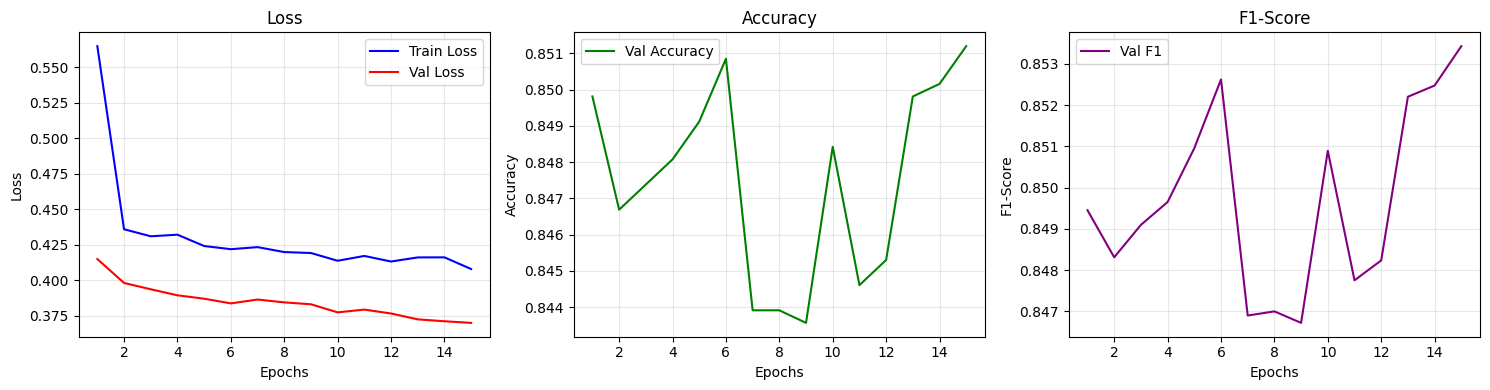


Final Metrics:
Train Loss: 0.4078
Val Loss: 0.3698
Val Accuracy: 0.8512
Val F1: 0.8534


In [55]:
plot_simple_results(res_cust_Cross)

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import torch

def plot_detailed_confusion_matrix(model, dataloader, device='cuda', class_names=None):
    """
    Детальная Confusion Matrix с дополнительной информацией
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            if isinstance(batch, dict):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
            else:
                input_ids = batch[0].to(device)
                attention_mask = batch[1].to(device)
                labels = batch[2].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            if hasattr(outputs, 'logits'):
                logits = outputs.logits
            else:
                logits = outputs

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    if class_names is None:
        class_names = ['Negative', 'Positive']  # для бинарной классификации

    # Создаем subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # 1. Обычная Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=ax1, cbar=False)
    ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')

    # Добавляем цветные значения
    for i in range(2):
        for j in range(2):
            color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
            ax1.text(j + 0.5, i + 0.5, str(cm[i, j]),
                    ha='center', va='center', color=color, fontweight='bold')

    # 2. Нормализованная Confusion Matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names,
                ax=ax2, cbar=False)
    ax2.set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Predicted Label')
    ax2.set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

    # Детальная статистика
    print("=" * 60)
    print("DETAILED STATISTICS")
    print("=" * 60)

    # Основные метрики
    accuracy = np.mean(np.array(all_labels) == np.array(all_preds))

    # Для бинарной классификации вычисляем precision, recall, f1 вручную
    TN, FP, FN, TP = cm.ravel()

    precision_0 = TN / (TN + FN) if (TN + FN) > 0 else 0
    recall_0 = TN / (TN + FP) if (TN + FP) > 0 else 0
    f1_0 = 2 * (precision_0 * recall_0) / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0

    precision_1 = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall_1 = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0

    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"\nClass {class_names[0]} (Negative):")
    print(f"  Precision: {precision_0:.4f}")
    print(f"  Recall:    {recall_0:.4f}")
    print(f"  F1-Score:  {f1_0:.4f}")

    print(f"\nClass {class_names[1]} (Positive):")
    print(f"  Precision: {precision_1:.4f}")
    print(f"  Recall:    {recall_1:.4f}")
    print(f"  F1-Score:  {f1_1:.4f}")

    print(f"\nConfusion Matrix Values:")
    print(f"  True Negatives (TN): {TN}")
    print(f"  False Positives (FP): {FP}")
    print(f"  False Negatives (FN): {FN}")
    print(f"  True Positives (TP): {TP}")


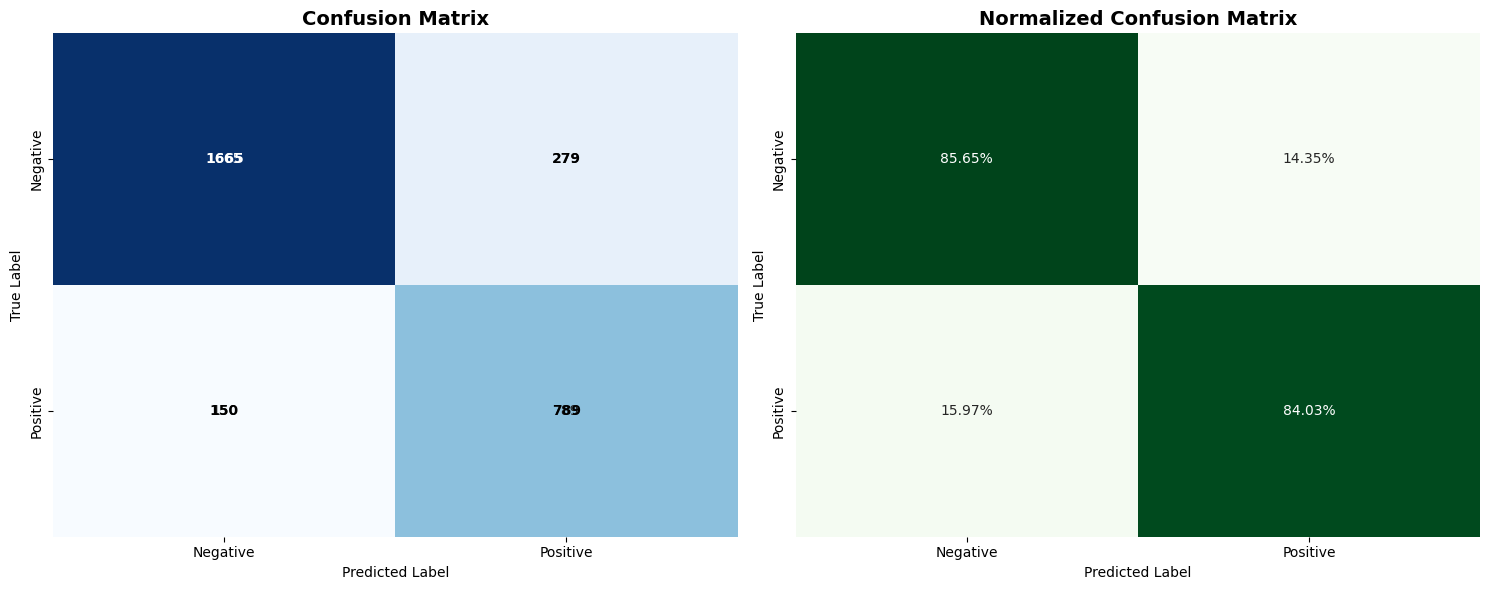

DETAILED STATISTICS
Overall Accuracy: 0.8512

Class Negative (Negative):
  Precision: 0.9174
  Recall:    0.8565
  F1-Score:  0.8859

Class Positive (Positive):
  Precision: 0.7388
  Recall:    0.8403
  F1-Score:  0.7862

Confusion Matrix Values:
  True Negatives (TN): 1665
  False Positives (FP): 279
  False Negatives (FN): 150
  True Positives (TP): 789


In [56]:
plot_detailed_confusion_matrix(model=model, dataloader=valid_RuBert_loader)

In [40]:
df['toxic'].value_counts()

,count
toxic,
0.0,9586
1.0,4826


In [41]:
res.keys()

dict_keys(['train_losses', 'val_losses', 'val_accuracies', 'val_f1_scores'])

In [57]:
checkpoint = {
    'epoch': len(res_cust_Cross['train_losses']),
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train loss': res_cust_Cross['train_losses'],
    'valid loss': res_cust_Cross['val_losses'],
    'accuracy': res_cust_Cross['val_accuracies'],
    'f1 score': res_cust_Cross['val_f1_scores'],
    'history': res_cust_Cross
}

In [58]:
from google.colab import files
torch.save(checkpoint, 'rubert_model_losss_optimized.pth')
files.download('rubert_model_losss_optimized.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>